<a href="https://colab.research.google.com/github/SURAJ28092001/bank_deposit_detection/blob/main/code/Brain_tumor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [ ]:
!pip install transformers datasets

In [ ]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
batch_size = 32

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/archive")

Resolving data files:   0%|          | 0/3061 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-0402fe20fa15f7bc/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3061
    })
})

In [ ]:
example = dataset["train"][2510]
example 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F3730B3F2D0>,
 'label': 1}

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['no', 'yes'], id=None)}

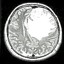

In [ ]:
example['image']

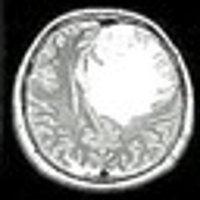

In [ ]:
example["image"].resize((200,200))

In [ ]:
example['label']

1

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['no', 'yes'], id=None)

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'yes'

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F372D5683D0>,
 'label': 1,
 'pixel_values': tensor([[[ 1.1872,  1.1872,  1.1872,  ..., -2.0323, -2.0323, -2.0323],
          [ 1.1872,  1.1872,  1.1872,  ..., -2.0323, -2.0323, -2.0323],
          [ 1.2214,  1.2214,  1.2214,  ..., -2.0323, -2.0323, -2.0323],
          ...,
          [ 0.1254,  0.1254,  0.1254,  ..., -1.9809, -1.9809, -1.9809],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.9809, -1.9809, -1.9809],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.9809, -1.9809, -1.9809]],
 
         [[ 1.3431,  1.3431,  1.3431,  ..., -1.9482, -1.9482, -1.9482],
          [ 1.3431,  1.3431,  1.3431,  ..., -1.9482, -1.9482, -1.9482],
          [ 1.3782,  1.3782,  1.3782,  ..., -1.9482, -1.9482, -1.9482],
          ...,
          [ 0.2577,  0.2577,  0.2577,  ..., -1.8957, -1.8957, -1.8957],
          [ 0.3102,  0.3102,  0.3102,  ..., -1.8957, -1.8957, -1.8957],
          [ 0.3102,  0.3102,  0.3102,  ..., -1.8957, -1

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-brainTumorData",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData into local empty directory.


In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2754
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 63


Epoch,Training Loss,Validation Loss,Accuracy
0,0.448800,0.194293,0.931596
1,0.216900,0.106833,0.951140
2,0.181200,0.086894,0.977199


***** Running Evaluation *****
  Num examples = 307
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-21
Configuration saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-21/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-21/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-21/preprocessor_config.json
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 307
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-42
Configuration saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-42/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/checkpoint-42/pytorch_model.bin
Feature extractor sa

Upload file pytorch_model.bin:   0%|          | 3.34k/105M [00:00<?, ?B/s]

Upload file runs/Oct19_13-25-35_b7fbf31e3f07/events.out.tfevents.1666185953.b7fbf31e3f07.52.0:  55%|#####4    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData
   6d80917..9433566  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData
   6d80917..9433566  main -> main

To https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData
   9433566..06510f4  main -> main

   9433566..06510f4  main -> main



***** train metrics *****
  epoch                    =        2.97
  total_flos               = 189728742GF
  train_loss               =      0.3342
  train_runtime            =  1:50:15.04
  train_samples_per_second =       1.249
  train_steps_per_second   =        0.01


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 307
  Batch size = 32


***** eval metrics *****
  epoch                   =       2.97
  eval_accuracy           =     0.9772
  eval_loss               =     0.0869
  eval_runtime            = 0:01:25.57
  eval_samples_per_second =      3.587
  eval_steps_per_second   =      0.117


In [ ]:
trainer.push_to_hub()

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-brainTumorData
Configuration saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-brainTumorData/preprocessor_config.json


Upload file runs/Oct19_13-25-35_b7fbf31e3f07/events.out.tfevents.1666193217.b7fbf31e3f07.52.2: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData
   06510f4..7b96403  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData
   06510f4..7b96403  main -> main



'https://huggingface.co/surajjoshi/swin-tiny-patch4-window7-224-finetuned-brainTumorData/commit/7b964036da4d8e17629a5119b4afb0d862c78e10'